Starting with 2 submission.
1. when the age column is removed
2. When the age_class is added and the age column is removed.

# Loan Approval Prediction.

## Overview

**Loan approval prediction as a classification problem involves categorizing loan applications into either "Approved" or "Rejected." This is achieved by analyzing features such as credit score, income, employment status, loan amount, and more.**

**Goal**: 
The goal for this competition is to predict whether an applicant is approved for a loan.

**Evaluation**
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

# Import

In [4]:
# importing libraries.
import pandas as pd
import numpy as np

# import the visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# modelling tools.
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
import optuna
import warnings
warnings.simplefilter("ignore")

In [7]:
# Creating a function that preprocess the data.
def wrangle(filepath):
    # Read the csv file.
    df = pd.read_csv(filepath, index_col= "id")

    return df

In [8]:
filepath = "/kaggle/input/playground-series-s4e10/train.csv"
df = wrangle(filepath)
df.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,age_group
id,,,,,,,,,,,,
0,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,30-39
1,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,20-29
2,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,20-29
3,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,30-39
4,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,20-29


In [9]:
# Checking the shape of the data.
df.shape

(58645, 12)

In [10]:
df.nunique()

person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
age_group                        8
dtype: int64

In [11]:
df.describe() # Getting the aggregate of the data.

,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_income               58645 non-null  int64   
 1   person_home_ownership       58645 non-null  object  
 2   person_emp_length           58645 non-null  float64 
 3   loan_intent                 58645 non-null  object  
 4   loan_grade                  58645 non-null  object  
 5   loan_amnt                   58645 non-null  int64   
 6   loan_int_rate               58645 non-null  float64 
 7   loan_percent_income         58645 non-null  float64 
 8   cb_person_default_on_file   58645 non-null  object  
 9   cb_person_cred_hist_length  58645 non-null  int64   
 10  loan_status                 58645 non-null  int64   
 11  age_group                   58645 non-null  category
dtypes: category(1), float64(3), int64(4), object(4)
memory usage: 5.4+ MB


In [13]:
# Checking if there is any column with null values.
df.isnull().sum()

person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
age_group                     0
dtype: int64

Perfect the Data is clean.

## EDA(Exploratory Data Analysis)

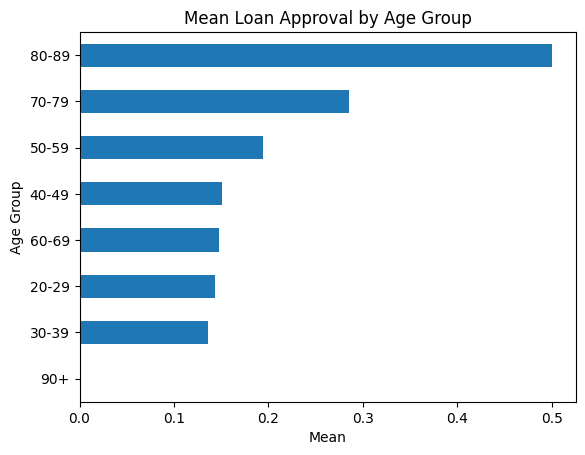

In [14]:
# Creating age group.
df_analysis = pd.read_csv(filepath, index_col="id")
bins = [20, 30, 40, 50, 60, 70, 80, 90, 130]
age_class = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]
df_analysis["age_group"] =pd.cut(df_analysis["person_age"], bins=bins, labels=age_class, right=False)
df_analysis.groupby(["age_group"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Mean Loan Approval by Age Group")
plt.ylabel("Age Group")
plt.xlabel("Mean");

Here is a very insightful display showing that people below the age group of 20-49 has very low probability of getting loan.
The age group of 90+ has very low probability of getting loan this can be because of the limited number of data for this age group.

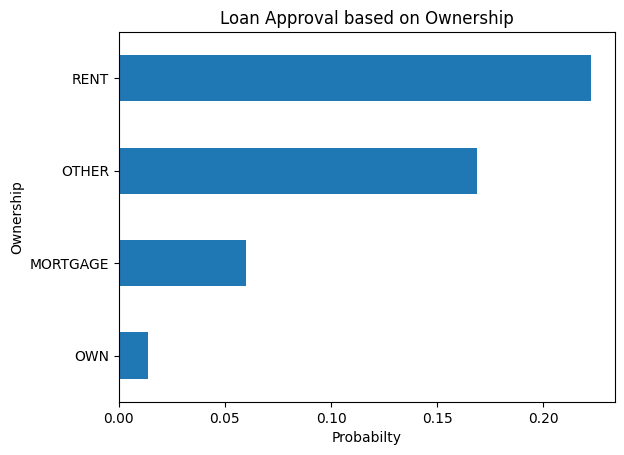

In [15]:
df_analysis.groupby(["person_home_ownership"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Loan Approval based on Ownership")
plt.xlabel("Probabilty")
plt.ylabel("Ownership");

Based on the Visualization above, it can be seen that people who rent a house are likely to get more loan in comparism with someone who own a house.

So this data is likely to be a Home/Rent Loan dataset.

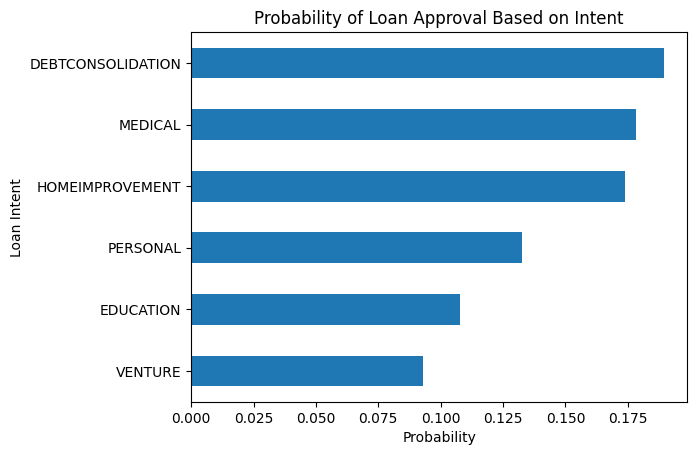

In [16]:
df_analysis.groupby(["loan_intent"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Probability of Loan Approval Based on Intent")
plt.ylabel("Loan Intent")
plt.xlabel("Probability");

From the dataset given. 

It is clearly visible that people who have the high chance of getting loan are those who intend to use the loan for `Debt consolidation`, `Medical` or `Home Improvement`

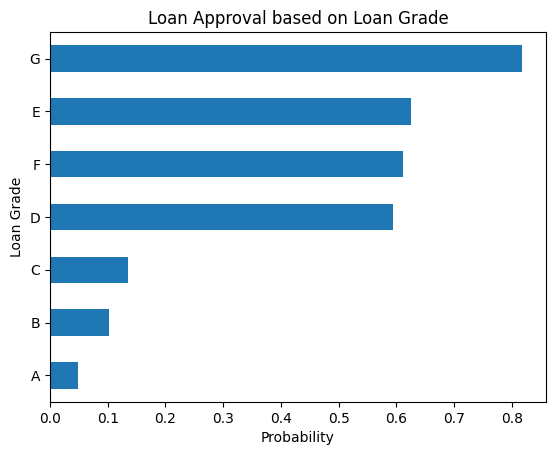

In [17]:
df.groupby(["loan_grade"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Loan Approval based on Loan Grade")
plt.ylabel("Loan Grade")
plt.xlabel("Probability");

Wow, this is giving us more insight into the data.

People in grade `A`, `B`, or `C` has less chance of getting loan.

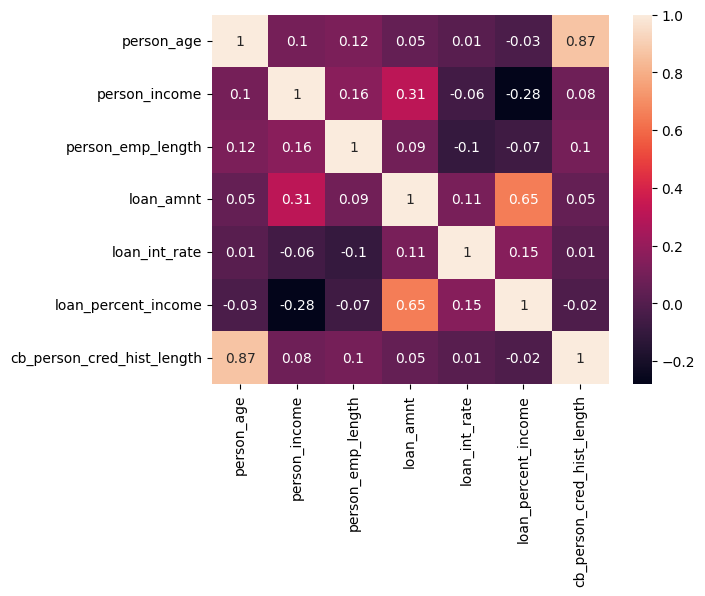

In [18]:
# Let's Check out the multi-collinearity of the numeric column with the target.
sns.heatmap(round(df_analysis.select_dtypes("number").drop(columns="loan_status").corr(), 2), annot=True);

In [19]:
abs(df_analysis.select_dtypes("number").corr()["loan_status"]).sort_values(ascending=False)

loan_status                   1.000000
loan_percent_income           0.378280
loan_int_rate                 0.338948
person_income                 0.169956
loan_amnt                     0.144982
person_emp_length             0.100428
cb_person_cred_hist_length    0.003030
person_age                    0.001130
Name: loan_status, dtype: float64

## Splitting Data.

In [20]:
# Feature matrix.
target = "loan_status"
X = df.drop(columns=target)
# Target Vector.
y = df[target]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((46916, 11), (46916,))

## Baseline Model

In [22]:
print(f"Baseline Model: {round(y_train.value_counts(normalize=True).max(), 2)}")

Baseline Model: 0.86


## Model

In [23]:
lgbm = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    MinMaxScaler(),
    XGBClassifier(random_state=42)
)
lgbm.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade', 'cb_person_default_on_file',
                                     'age_group'],
                               use_cat_names=True)),
                ('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=Non...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [24]:
y_test_pred= lgbm.predict(X_test)
roc_auc_score(y_test, y_test_pred)

0.8641690918726929

## Feature Engineering.

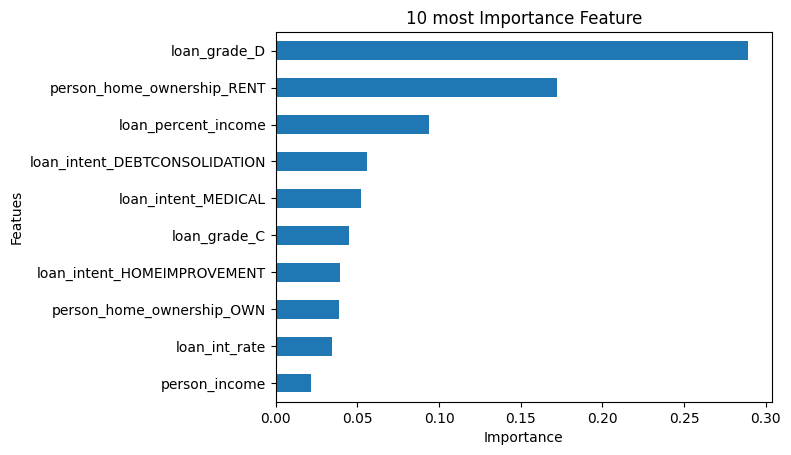

In [25]:
output = 10
feat= lgbm.named_steps["onehotencoder"].get_feature_names()
imp = lgbm.named_steps["xgbclassifier"].feature_importances_
pd.Series(imp, index=feat).sort_values().tail(output).plot(kind="barh")
plt.title(f"{output} most Importance Feature")
plt.ylabel("Featues")
plt.xlabel("Importance");

## Fine Tuning with optuna.

In [ ]:
# def objective(trial):
#     params= {
#         "max_depth": trial.suggest_int("max_depth", 2, 15),
#         "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
# #         "min_child_weight": trial.suggest_int("min_child_weight", 0, 15),
#         "subsample": trial.suggest_float("subsample", 0.1, 0.5),
# #         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.0, 1.0),
# #         "colsample_bylevel": trial.suggest_float("colsample_bytree", 0.0, 1.0),
# #         "colsample_bynode": trial.suggest_float("colsample_bytree", 0.0, 1.0),
#         "n_estimators":trial.suggest_int("n_estimators", 500, 2000)
#     }
#     model = make_pipeline(
#             OneHotEncoder(use_cat_names=True),
#             MinMaxScaler(),
#             XGBClassifier(**params, random_state=42)
#         )
#     model.fit(X_train, y_train)
#     predict = model.predict_proba(X_test)[:, 1]
#     score = roc_auc_score(y_test, predict)
#     return score
# study = optuna.create_study(study_name="XGB", direction="maximize")
# study.optimize(objective, n_trials=100, show_progress_bar=True)

In [ ]:
# study.best_params

## Moment of Truth.

In [26]:
test_filepath = "/kaggle/input/playground-series-s4e10/test.csv"
df_test = wrangle(test_filepath)
test_pred = lgbm.predict_proba(df_test)[:, 1]
pd.DataFrame({"loan_status": test_pred}, index= df_test.index).to_csv("submission.csv")